<a href="https://colab.research.google.com/github/MaiMejia/ML-Projects/blob/main/ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><b>Computer Vision: Detecting whether Images are Flip or not</b>
</hh2>

#### <b> Table of Content</b>  

1.  <a href="#Context">Context</a>
1. <a href="#Importing Libraries">Importing Libraries</a>
2.  <a href="#Unzipping the Data">Unzipping the Data</a>
1.  <a href="#Preparing and Exploring Images">Preparing and Exploring Images</a>
1. <a href="#Modeling">Modeling</a><br>
     <a href="#Basic CNN"> i) Basic CNN</a> <br>
     <a href="#Pre-trained Model: ResNet50"> ii) Pre-trained Model: ResNet50</a><br>

  <a href="#Final Notes">Final Notes</a>

<a name="Context"></a>
#### <b> 1. Context</b>   
<p> A start-up develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries.<br> <b>Machines that can see:</b> Their solutions in small yet intelligent devices that can be easily integrated to your existing data flow.<br> <b>Computer vision for everyone:</b> Their devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion.</p><br>

<p><b>MonReader</b> is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk.<br>
It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.</p>

<b>Goal:</b> Predict if the page is being flipped using a single image.

<b>Data:</b> They collected page flipping images from smart phones and labelled them as flipping and not flipping.

<a name="Importing Libraries"></a>
#### <b> 2. Importing Libraries</b>   

In [ ]:

# Data Analysis
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Loading and preparing data
from google.colab import drive
import zipfile
from zipfile import ZipFile
import requests
import os
import io
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2  # OpenCV to resize images
from scipy import ndimage


# Resizing the images
from PIL import Image

# Data processing
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Mount Google Drive
drive.mount('/content/drive')

# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

Mounted at /content/drive


<a name="Unzipping the Data"></a>
#### <b> 3. Unzipping the Data</b>

In [ ]:
# Unzip the images file and downloading the file
with ZipFile('/content/drive/My Drive/Colab Notebooks/Proj4/images.zip', 'r') as zip:
  zip.extractall('/content/drive/My Drive/Colab Notebooks/Proj4/')  # Define the desired path to save the unzip data
  zip.close()

In [ ]:
trainpath = '/content/drive/My Drive/Colab Notebooks/Proj4/images/training'  # Directory containing the train data
testpath = '/content/drive/My Drive/Colab Notebooks/Proj4/images/testing'  # Directory containing the train data

<a name="Preparing and Exploring Images"></a>
#### <b> 4. Preparing and Exploring Images</b>

In [ ]:
# Number of test images

test_dir = '/content/drive/My Drive/Colab Notebooks/Proj4/images/testing'
total_test_images = sum(len(files) for _, _, files in os.walk(test_dir))
print(total_test_images)


597


In [ ]:
# Splitting images
train = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/Proj4/images/training',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    subset='training',
    validation_split=0.2,
    seed=42,
    label_mode='int'
    )

validation = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/Proj4/images/training',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    subset='validation',
    validation_split=0.2,
    seed=42,
    label_mode='int'
    )

test = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/Proj4/images/testing',
    batch_size=597,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    label_mode='int'
    )

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Found 2392 files belonging to 2 classes.
Using 478 files for validation.
Found 597 files belonging to 2 classes.


In [ ]:
test_images, test_labels = next(iter(test))

##### <b> Visualizing Images</b>

In [ ]:
for images, labels in train.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Labels:", labels.numpy())

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Labels: [1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0]


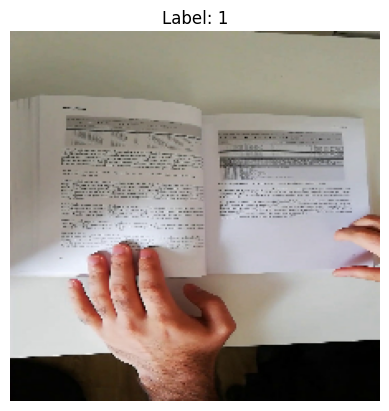

In [ ]:
### Orginal image
for images, labels in train.take(1):
  image = images[0].numpy().astype("uint8")
  label = labels[0]

  plt.imshow(image)
  plt.title(f"Label: {label}")
  plt.axis("off")

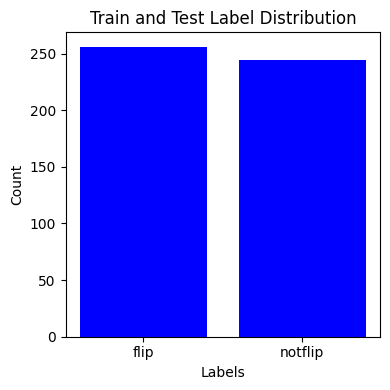

In [ ]:
# Visualizing data distribution

labels_list = []

for image, labels in train.unbatch().take(500):
    labels_list.append(int(labels.numpy()))

# Classifying labels
mapped_labels = pd.Series(labels_list).map({0: 'notflip', 1: 'flip'})
labels_counts = mapped_labels.value_counts()

#Plotting the Labels Distribution
fig, ax = plt.subplots(figsize=(4, 4))

ax.bar(labels_counts.index, labels_counts.values, color='blue')
ax.set_title('Train and Test Label Distribution')
ax.set_xlabel('Labels')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

##### Visualizing Training Labels

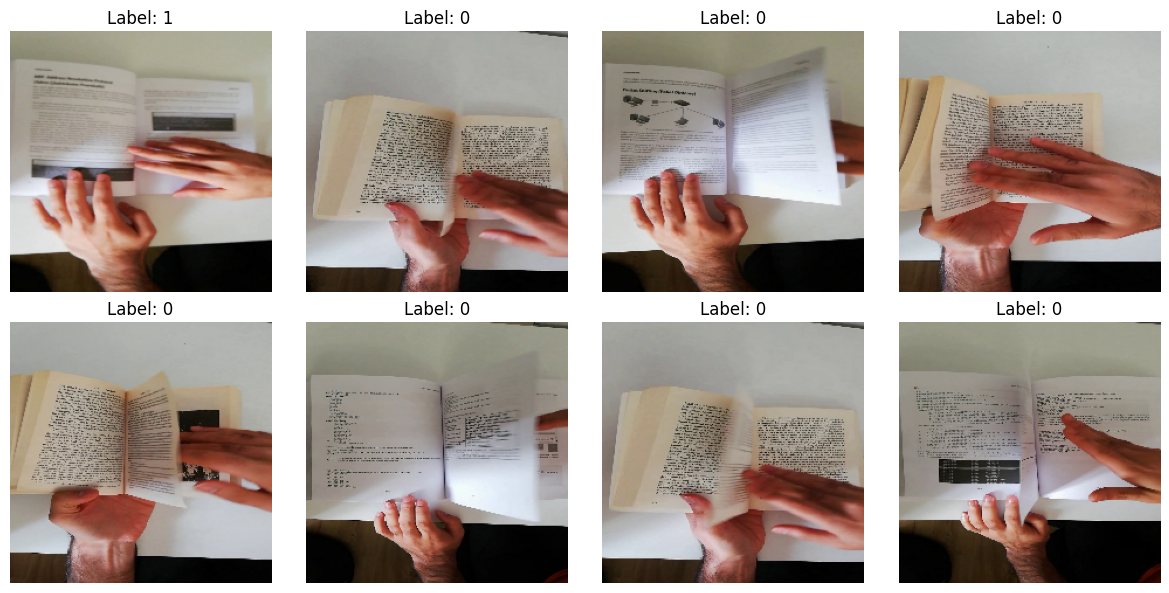

In [ ]:
# Plotting some images -- 0: notflip, 1: flip

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, (images, labels) in enumerate(train.take(8)):
    image = images[0].numpy().astype("uint8")
    label = labels[0].numpy()

    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

<a name="Modeling"></a>
#### <b>5. Modeling</b>

In [ ]:
# Setting the Seed
import random

# Build the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, InputLayer,Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization,LeakyReLU, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import binary_crossentropy, Accuracy

# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

<a name ="Basic CNN"></a>
##### <b>i) Basic CNN</b>

In [ ]:
# Clean Keras backend
from keras import backend
backend.clear_session()

# Set the seed
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

def cnn_model():

# Initializing the sequential model
  cnn_model = Sequential()

  cnn_model.add(InputLayer(shape=(224, 224, 3)))     # This layer needs to be fed with the initial images size

  cnn_model.add(Conv2D(64, kernel_size = (3,3), activation='relu'))   # 1st Convolutional layer
  cnn_model.add(BatchNormalization())
  cnn_model.add(layers.MaxPooling2D((2, 2)))

  cnn_model.add(Conv2D(32, kernel_size = (3,3), activation='relu'))   # 2nd Convolutional layer
  cnn_model.add(BatchNormalization())
  cnn_model.add(layers.MaxPooling2D((2, 2)))

  cnn_model.add(GlobalAveragePooling2D())

  cnn_model.add(Dense(16, activation = 'relu'))     # Fully connected Dense layer
  cnn_model.add(Dense(1, activation = 'sigmoid'))

  return cnn_model

  # Compiling the model defining loss, optimizer and performance metric
cnn_model = cnn_model()

cnn_model.compile(loss = 'binary_crossentropy',
                optimizer = Adam(learning_rate=0.001),
                metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,185 (82.75 KB)

 Trainable params: 20,993 (82.00 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Adding Callbacks

# Early Stop
early_stopping = EarlyStopping(monitor = 'val_loss',          # try val_accuracy
                                        patience = 2,
                                        restore_best_weights = True,
                                        verbose = 1
                                        )

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                            factor = 0.5,
                            patience = 2,
                            verbose = 1
                              )

# Add Checkpoint
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/Proj4/models/cnn_best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

# Fitting and training  the model
cnn_history = cnn_model.fit(train,
                            epochs=20,
                            batch_size=32,
                            validation_data = validation,
                           callbacks=[early_stopping, reduce_lr, checkpoint])


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6959 - loss: 0.6052
Epoch 1: val_loss improved from inf to 6.02438, saving model to /content/drive/MyDrive/Colab Notebooks/Proj4/models/cnn_best_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 587s 8s/step - accuracy: 0.6968 - loss: 0.6044 - val_accuracy: 0.5251 - val_loss: 6.0244 - learning_rate: 0.0010
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8132 - loss: 0.4551
Epoch 2: val_loss improved from 6.02438 to 2.45756, saving model to /content/drive/MyDrive/Colab Notebooks/Proj4/models/cnn_best_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 460s 7s/step - accuracy: 0.8134 - loss: 0.4548 - val_accuracy: 0.5251 - val_loss: 2.4576 - learning_rate: 0.0010
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8387 - loss: 0.3955
Epoch 3: val_loss did not improve from 2.45756
60/60 ━━━━━━━━━━━━━━━━━━━━ 452s 7s/step - accuracy: 0.8385 - loss: 0.3955 - val_accuracy: 0.5251 - val_loss: 2.6425 - learning_rate: 0.0010
Epoch 

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test,
                                               batch_size=32)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 147s 147s/step - accuracy: 0.5762 - loss: 0.6908
Test Loss: 0.6908199787139893
Test Accuracy: 0.5762144327163696


In [ ]:
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Training and Validation Accuracy',
                                    'Training and Validation Loss'))


fig.add_trace(go.Scatter(x=cnn_history.epoch,
                         y=cnn_history.history['accuracy'],
                         name='Training Accuracy'),
                        row=1, col=1)

fig.add_trace(go.Scatter(x=cnn_history.epoch,
                         y=cnn_history.history['val_accuracy'],
                         name='Validation Accuracy'),
                        row=1, col=1)


fig.add_trace(go.Scatter(x=cnn_history.epoch,
                         y=cnn_history.history['loss'],
                         name='Training Loss'),
                        row=1, col=2)

fig.add_trace(go.Scatter(x=cnn_history.epoch,
                         y=cnn_history.history['val_loss'],
                         name='Validation Loss'),
                        row=1, col=2)

fig.update_layout( title_text="CNN Simplified Model - Training and Validation Accuracy and Loss")
fig.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 976ms/step


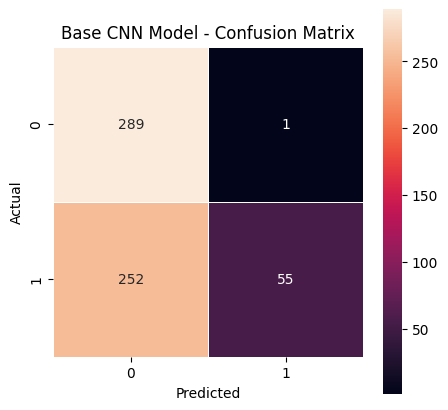

In [ ]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

test_images, test_labels = next(iter(test))

# Get predictions
y_pred = cnn_model.predict(test_images)  # Get model predictions (probabilities)
y_pred_classes = np.round(y_pred)  # Predicted classes (0 or 1)

# Convert one-hot encoded test labels to single class indices
y_true = np.concatenate([y for x, y in test], axis=0)  # True classes (0 or 1

# Compute the confusion matrix
conf_matrix = tf.math.confusion_matrix(test_labels, y_pred_classes)

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, linewidths=0.4, fmt='d', square=True, ax=ax)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Base CNN Model - Confusion Matrix')
plt.show()

In [ ]:
class_report = classification_report(test_labels, y_pred_classes, target_names=['Class 0', 'Class 1'])
print(class_report)

              precision    recall  f1-score   support

     Class 0       0.53      1.00      0.70       290
     Class 1       0.98      0.18      0.30       307

    accuracy                           0.58       597
   macro avg       0.76      0.59      0.50       597
weighted avg       0.76      0.58      0.49       597



<a name="Pre-trained Model: ResNet50"></a>
##### <b>ii) Pre-trained Model: ResNet50 </b>

In [ ]:
# Clean Keras backend
from keras import backend
backend.clear_session()

In [ ]:
# Image Augmentation
img_augmentation = models.Sequential(
    [layers.RandomRotation(factor=0.15),
     layers.RandomFlip()
    ])

In [ ]:
# Import dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications.resnet50 import ResNet50

# Set the seed
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

resnet = ResNet50(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
resnet.trainable = False  #freeze the base

resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Connecting the model
model = Sequential([
    InputLayer(shape=(224, 224, 3)),
    img_augmentation,
    resnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
                optimizer = Adam(learning_rate=0.001),
                metrics = ['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,727,361 (90.51 MB)

 Trainable params: 135,425 (529.00 KB)

 Non-trainable params: 23,591,936 (90.00 MB)

In [ ]:
# Early Stop
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=2,
                               restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=2, verbose=1)


# Checkpoint
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/Proj4/models/resnet50_best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

history = model.fit(train,
                    epochs=40,
                    validation_data= validation,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6902 - loss: 0.6775
Epoch 1: val_loss improved from inf to 0.51511, saving model to /content/drive/MyDrive/Proj4/models/resnet50_best_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 352s 6s/step - accuracy: 0.6914 - loss: 0.6750 - val_accuracy: 0.7134 - val_loss: 0.5151 - learning_rate: 0.0010
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8459 - loss: 0.3525
Epoch 2: val_loss improved from 0.51511 to 0.24544, saving model to /content/drive/MyDrive/Proj4/models/resnet50_best_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 310s 5s/step - accuracy: 0.8460 - loss: 0.3523 - val_accuracy: 0.9163 - val_loss: 0.2454 - learning_rate: 0.0010
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8642 - loss: 0.3088
Epoch 3: val_loss improved from 0.24544 to 0.24532, saving model to /content/drive/MyDrive/Proj4/models/resnet50_best_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 318s 5s/step - accuracy: 0.8644 - loss: 0.3084 - val_accur

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test,
                                               batch_size=32)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 87s 87s/step - accuracy: 0.9514 - loss: 0.1355
Test Loss: 0.13549931347370148
Test Accuracy: 0.9514237642288208


In [ ]:
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Training and Validation Accuracy',
                                    'Training and Validation Loss'))


fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['accuracy'],
                         name='Training Accuracy'),
                        row=1, col=1)

fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_accuracy'],
                         name='Validation Accuracy'),
                        row=1, col=1)


fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['loss'],
                         name='Training Loss'),
                        row=1, col=2)

fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_loss'],
                         name='Validation Loss'),
                        row=1, col=2)

fig.update_layout( title_text="CNN Simplified Model - Training and Validation Accuracy and Loss")
fig.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step


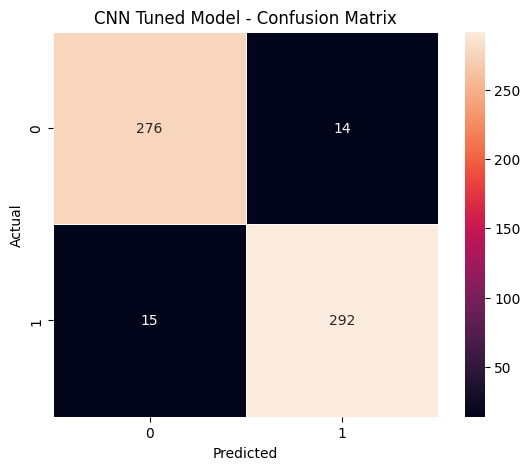

In [ ]:
# Get predictions
y_pred = model.predict(test_images)  # Get model predictions (probabilities)
y_pred_classes = np.round(y_pred)

# Compute the confusion matrix
conf_matrix = tf.math.confusion_matrix(test_labels, y_pred_classes)

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, linewidths=0.4, fmt='d', square=True, ax=ax)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Tuned Model - Confusion Matrix')
plt.show()

<a id="sec-2"></a>
<h4 style="font-size:10px; font-weight:bold; margin-bottom:4px;"><b>Confusion Matrix Interpretation</b></h4>  
<br>

<table border="1" style="border-collapse: collapse; text-align: center;">
  <tr>
    <th></th>
    <th>Predicted: 0 (notflip)</th>
    <th>Predicted: 1 (flip)</th>
  </tr>
  <tr>
    <th>Actual: 0 (notflip)</th>
    <td>TN</td>
    <td>FP</td>
  </tr>
  <tr>
    <th>Actual: 1 (flip)</th>
    <td>FN</td>
    <td>TP</td>
  </tr>
</table>

<br>
<p style="font-size:12px; line-height:1.5; margin-top:0px; margin-bottom:4px;">
Classes: 0 (notflip) and 1 (flip) <br>
<b>TN (True Negative)</b>: Correctly predicted as notflip <br>
<b>FP (False Positive)</b>: Incorrectly predicted as flip vs. actual notflip<br>
<b>FN (False Negative)</b>: Incorrectly predicted notflip vs. actual flip<br>
<b>TP (True Positive)</b>: Correctly predicted flip <br>
FP might represent a higher cost for the company, because they will be missing notflip cases.</p>
<br>

In [ ]:
# Print classification report
report = classification_report(test_labels, y_pred_classes, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.95      0.95      0.95       290
     Class 1       0.95      0.95      0.95       307

    accuracy                           0.95       597
   macro avg       0.95      0.95      0.95       597
weighted avg       0.95      0.95      0.95       597



<a name="Final Notes"></a>
#### <b>Final Notes</b>

* After running several CNNs, starting from a <b>Basic model</b> and moving into tuning versions, there was no improvement. Those models resulting in overfitted versions, the training accuracy curve was always higher than the validation accuracy curve.
*   So, the next step was to build a <b>CNN integrating Augmented data and a Pre-trained Model</b>. The metrics of this model were by far much better and solved the problem of overfitting.
